## Imports

In [13]:
import os
import sys
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from PIL import Image

repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))
from pkg import models


%load_ext autoreload
%autoreload 2

## Model definition

In [5]:
model_names = ['microsoft/resnet-18', 'Visual-Attention-Network/van-tiny']

model_name = model_names[1]

predictor = models.GlassProbaPredictor(model_name)

/Users/user/Main/Study/НИС/hse-ml-nis/pkg/models.py:32: UserWarning: This module is deprecated
  warnings.warn('This module is deprecated')


In [6]:
type(predictor.feature_extractor)

transformers.models.convnext.image_processing_convnext.ConvNextImageProcessor

## Data inference example

In [27]:
def inference_on_images(predictor, images):
    probs = []
    inference_times = []

    for im in images:
        im = np.array(im)
        time1 = time.time_ns()
        prob = predictor.predict_proba(im)
        probs.append(prob)
        time2 = time.time_ns()
        inference_times.append((time2 - time1) / 10 ** 9)

    return probs, inference_times

In [34]:
data_dir = repo_dir / 'demo_data'
ims = [Image.open(im_fp).convert('RGB')
       for im_fp in data_dir.glob('*')]

Downloading:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

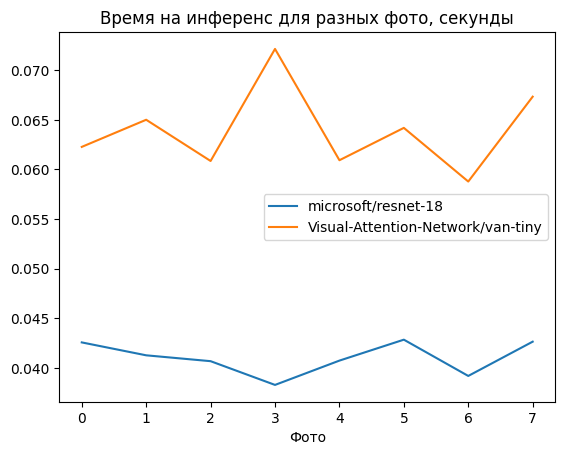

In [37]:
for model_name in model_names:
    predictor = models.GlassProbaPredictor(model_name)
    probs, inference_times = inference_on_images(predictor, ims)

    plt.plot(inference_times, label=model_name)
    plt.xlabel('Фото')
    plt.title('Время на инференс для разных фото, секунды')

plt.legend();

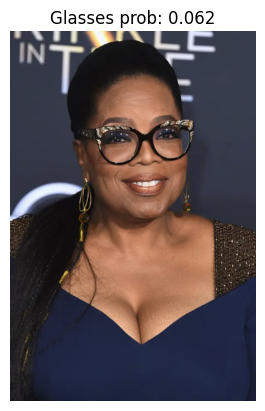

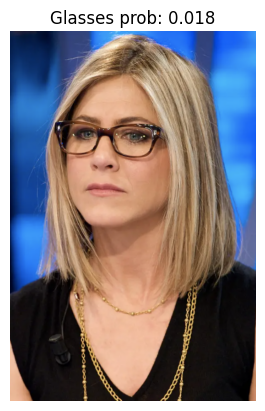

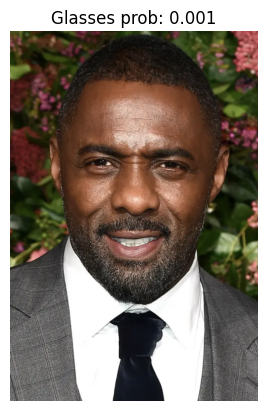

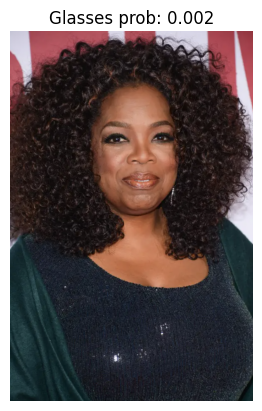

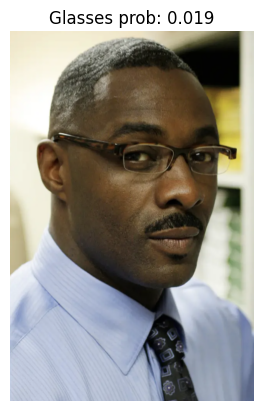

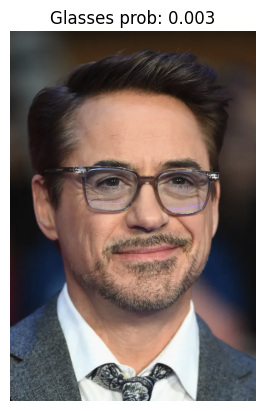

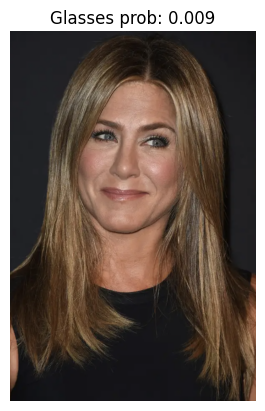

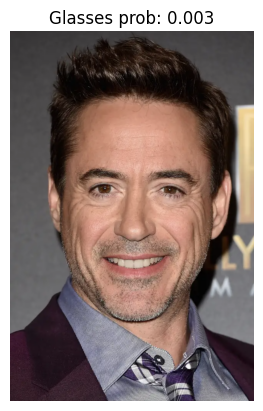

In [32]:
for im, prob in zip(ims, probs):

    im = np.array(im)
    plt.imshow(im)
    plt.axis('off')
    plt.title(f'Glasses prob: {prob:.3f}')
    plt.show()

## Dataset to finetune the model

In [14]:
from pkg.dataset import MeGlassDataset
from scripts.download_dataset import download_meglass

data_dir = repo_dir / 'data'
dataset_dir, labels_fp = download_meglass(data_dir)
dataset = MeGlassDataset(dataset_dir, labels_fp)
loader = torch.utils.data.DataLoader(dataset)

In [8]:
# Примеры фото из датасета
max_i = 0

for i, batch in enumerate(loader):

    if i == max_i:
        break

    im = batch['image'][0]
    im = np.array(im)
    im = im.transpose(1, 2, 0)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

## Train

In [4]:
%tensorboard --logdir .

UsageError: Line magic function `%tensorboard` not found.


In [16]:
from scripts.train import train

train(
    dataset_dir,
    labels_fp,
)

Train size: 9
Val size: 0
Test size: 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MisconfigurationException: The provided lr scheduler `WarmUpScheduler` doesn't follow PyTorch's LRScheduler API. You should override the `LightningModule.lr_scheduler_step` hook with your own logic if you are using a custom LR scheduler.

In [11]:
import torch
import matplotlib.pyplot as plt
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup


optimizer = torch.optim.AdamW([torch.tensor(1)], lr=1e-3)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 60],
    gamma=0.1,
)

scheduler = create_lr_scheduler_with_warmup(
    scheduler,
    warmup_start_value=1e-7,
    warmup_duration=10,
)

lrs = []
for _ in range(100):
    optimizer.step()
    lrs.append(scheduler.get_param())
    scheduler.step()


plt.plot(lrs)

AttributeError: 'ParamGroupScheduler' object has no attribute 'get_param'

In [9]:
from collections import Counter

d = Counter([200, 250])
d[250]

1

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


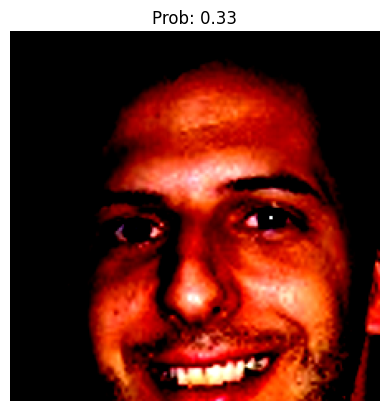

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


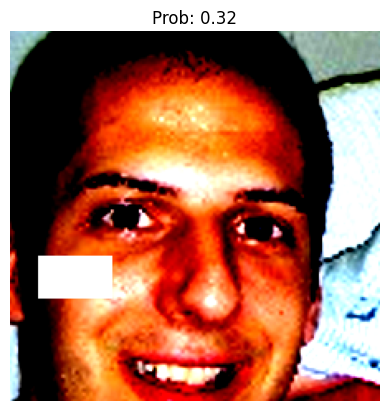

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


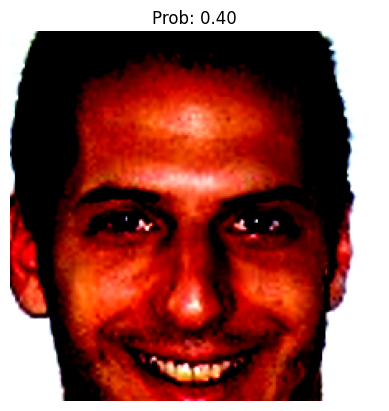

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


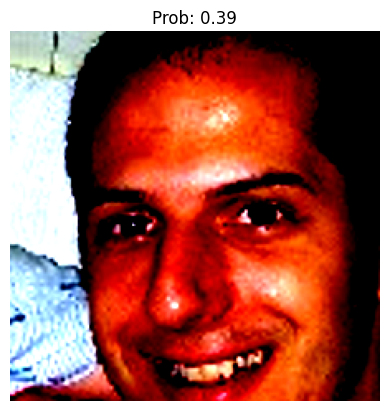

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


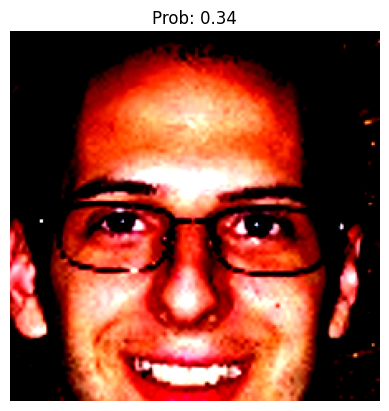

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


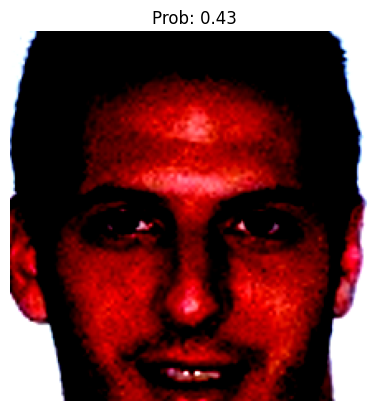

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


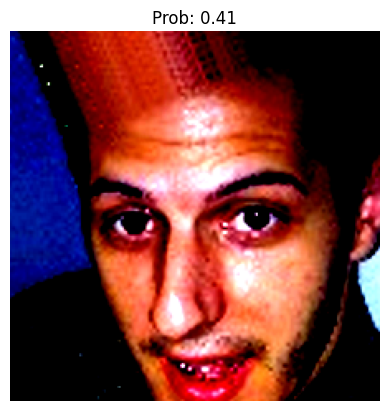

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


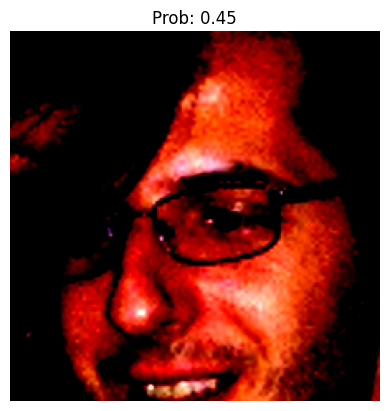

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


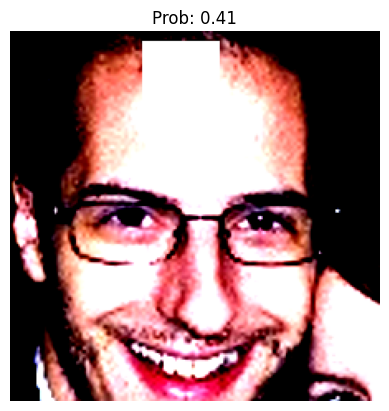

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


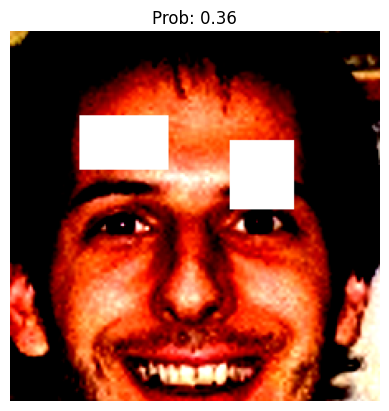

In [9]:
from pkg.models import GlassProbaPredictorTrained

checkpoint_dir = Path('lightning_logs/version_1/checkpoints')

model = GlassProbaPredictorTrained.load_from_checkpoint(
    checkpoint_dir / "epoch=12-step=1300.ckpt",
    hf_model_name='microsoft/resnet-18',
)
model.eval()

max_i = 10

for i, batch in enumerate(loader):

    if i == max_i:
        break

    im = batch['image'][0]
    im = np.array(im)
    im = im.transpose(1, 2, 0)
    
    with torch.no_grad():
        prob = model.forward(batch['image']).sigmoid().item()
    
    plt.imshow(im)
    plt.title(f'Prob: {prob:.2f}')
    plt.axis('off')
    plt.show()